## Importing Libs

In [132]:
import pandas as pd
import s2sphere
import math
import networkx as nx
from shapely.geometry import box, point
import folium
import random
import numpy as np
from sklearn.neighbors import BallTree, KDTree
import math
from pprint import pprint
import os
from pyhive import hive
from TCLIService.ttypes import TOperationState
import json

## Reading raw data from file.

In [3]:
raw = pd.read_table("../distances_samik_data/latlng.csv", sep=',')

In [4]:
raw.head()

,accountid,eventtime,latitude,longitude,networkidentifier,networktype
0,ACC7E025D1040AF4AE5864396C9D660CD617,2017-01-05 00:21:33.0,12.918876,77.635025,0a5cc3c014ff2454b485bfd43d6d374e,WiFi
1,ACCC7C2E5E9429847D49DDDDBC7D9DF16382,2017-01-05 00:23:41.0,12.906050,77.566644,1f2cdadaf952ec20f6adb53f429b46cd,WiFi
2,ACCFFC1EB1DBDD04A04A92F51B20C4B28798,2017-01-05 00:56:21.0,12.979481,77.638086,7cac746b1ece0a0d2a2575aa7094c41e,WiFi
3,ACYAZEGXPK5V848J9D4FYEZ3Z83Y9944,2017-01-05 00:56:38.0,12.975563,77.641075,f6f8ca1ed640b8a47a692332d6cd0a19,WiFi
4,ACC13708419899612431,2017-01-05 00:34:13.0,13.014428,77.666900,f6f8ca1ed640b8a47a692332d6cd0a19,unknown


In [5]:
raw.describe()

,latitude,longitude
count,6.944466e+06,6.944466e+06
mean,1.295709e+01,7.762413e+01
std,7.158905e-02,7.135755e-02
min,1.265819e+01,7.732538e+01
25%,1.291501e+01,7.757381e+01
50%,1.295807e+01,7.762153e+01
75%,1.300130e+01,7.767589e+01
max,1.323497e+01,7.783579e+01


In [6]:
raw.describe(include=['O'])

,accountid,eventtime,networkidentifier,networktype
count,6746011,6944466,6944466,6944466
unique,508698,2272091,264546,5
top,ACC97D6FC31BD524691ACD2A094124CE3B5O,2016-12-18 16:01:48.0,f6f8ca1ed640b8a47a692332d6cd0a19,WiFi
freq,2023,57,1926791,4796079


## Checking for  discrepancies

Ideally each this data is acquired for Wifi network type. But due to potential bugs there are multiple network types with a networkidentifier. Most of these networkidentifier are distributed across Bangalore. We will need to eliminate such rows.

In [7]:
anal_df = raw.groupby('networkidentifier')['networktype'].apply(lambda x: len(x.unique()))
anal_df=anal_df.to_frame()
morethan3unique  = float(anal_df.loc[(anal_df.networktype > 3)].count())/anal_df.loc[(anal_df.networktype >= 1)].count();
exactly1unique = float(anal_df.loc[(anal_df.networktype == 1)].count())/anal_df.loc[(anal_df.networktype >= 1)].count();
exactly2unique = float(anal_df.loc[(anal_df.networktype == 2)].count())/anal_df.loc[(anal_df.networktype >= 1)].count();
anal_df.loc[(anal_df.networktype == 2)];

## Removal of aforementioned rows.

Ideally, a network identifier should be confined to a small area, but some network identifiers are distributed across the city. 

Will remove these by thresholding the rsme of the distance (in meteres) from the centroid of the points for each networkidentifier.

## Appending the centroid of lat long to the frame.

In [8]:
raw = raw.join(raw.groupby('networkidentifier')['latitude'].mean(), on='networkidentifier', rsuffix='_mean')
raw = raw.join(raw.groupby('networkidentifier')['longitude'].mean(), on='networkidentifier', rsuffix='_mean')

In [9]:
raw = raw.sort_values('networkidentifier')

## Appending the distance from centroid column

Calculating distance by multiplying radius of Earth by arc angle. This works for small distance and erronous for distances beyond cities.

In [10]:
earthRadius = 6371000
def distance_from_center(x):
    center = s2sphere.LatLng.from_degrees(x[6], x[7])
    other = s2sphere.LatLng.from_degrees(x[2], x[3])
    return center.get_distance(other).radians * earthRadius


In [11]:
raw['distance_from_centeroid'] = raw.apply(distance_from_center, axis=1)

In [12]:
raw = raw.sort_values(['networkidentifier', 'distance_from_centeroid'], ascending=False)

## Appending the mean of the centroid distances.

In [13]:
raw = raw.join(raw.groupby('networkidentifier')['distance_from_centeroid'].mean(), on='networkidentifier', rsuffix='_mean')

In [14]:
raw.head(2)

,accountid,eventtime,latitude,longitude,networkidentifier,networktype,latitude_mean,longitude_mean,distance_from_centeroid,distance_from_centeroid_mean
1085983,ACC0D25857369564A4AB71F1D2E7CED33D3M,2016-12-09 13:16:26.0,13.033957,77.517109,ffffeced34aed57acd05049e223e9fda,3G,13.033957,77.517109,0.000000,0.000000
5847554,ACCCC6CB4911CE44FC88BC9C740CEAD2BBCE,2016-12-01 14:45:24.0,12.912615,77.579315,ffffe67a151361149fca3fafa3bf4d3c,WiFi,12.911819,77.579151,90.243756,15.977361


## Calculating rmse of the distances

In [15]:
raw['absdiff'] = (raw['distance_from_centeroid']-raw['distance_from_centeroid_mean'])**2

raw['absdiff'] = raw['absdiff'].apply(math.sqrt)

In [16]:
raw.head(2)

,accountid,eventtime,latitude,longitude,networkidentifier,networktype,latitude_mean,longitude_mean,distance_from_centeroid,distance_from_centeroid_mean,absdiff
1085983,ACC0D25857369564A4AB71F1D2E7CED33D3M,2016-12-09 13:16:26.0,13.033957,77.517109,ffffeced34aed57acd05049e223e9fda,3G,13.033957,77.517109,0.000000,0.000000,0.000000
5847554,ACCCC6CB4911CE44FC88BC9C740CEAD2BBCE,2016-12-01 14:45:24.0,12.912615,77.579315,ffffe67a151361149fca3fafa3bf4d3c,WiFi,12.911819,77.579151,90.243756,15.977361,74.266394


In [17]:
size = raw.groupby('networkidentifier').size()

In [18]:
rmse = raw.groupby('networkidentifier')['absdiff'].sum()/size

In [19]:
rmse = rmse.to_frame()

In [20]:
raw = raw.join(rmse, on='networkidentifier', rsuffix='_1')

In [21]:
raw = raw.rename(columns={0: 'rmse'})
raw

,accountid,eventtime,latitude,longitude,networkidentifier,networktype,latitude_mean,longitude_mean,distance_from_centeroid,distance_from_centeroid_mean,absdiff,rmse
1085983,ACC0D25857369564A4AB71F1D2E7CED33D3M,2016-12-09 13:16:26.0,13.033957,77.517109,ffffeced34aed57acd05049e223e9fda,3G,13.033957,77.517109,0.000000,0.000000,0.000000,0.000000
5847554,ACCCC6CB4911CE44FC88BC9C740CEAD2BBCE,2016-12-01 14:45:24.0,12.912615,77.579315,ffffe67a151361149fca3fafa3bf4d3c,WiFi,12.911819,77.579151,90.243756,15.977361,74.266394,12.377732
855707,ACC13575442286923803,2016-12-14 11:15:19.0,12.911807,77.579046,ffffe67a151361149fca3fafa3bf4d3c,WiFi,12.911819,77.579151,11.403372,15.977361,4.573990,12.377732
4286486,ACC13575442286923803,2016-12-15 09:01:21.0,12.911735,77.579149,ffffe67a151361149fca3fafa3bf4d3c,WiFi,12.911819,77.579151,9.346082,15.977361,6.631280,12.377732
848741,ACC13575442286923803,2016-12-14 10:41:19.0,12.911735,77.579152,ffffe67a151361149fca3fafa3bf4d3c,WiFi,12.911819,77.579151,9.322412,15.977361,6.654949,12.377732
848050,ACC13575442286923803,2016-12-14 10:41:55.0,12.911737,77.579151,ffffe67a151361149fca3fafa3bf4d3c,WiFi,12.911819,77.579151,9.143046,15.977361,6.834316,12.377732
4964989,ACC2D74D8D5054A436485D6BECB3B7994C6F,2016-12-31 20:42:39.0,12.911738,77.579147,ffffe67a151361149fca3fafa3bf4d3c,WiFi,12.911819,77.579151,9.028472,15.977361,6.948889,12.377732
845564,ACC13575442286923803,2016-12-14 10:29:41.0,12.911739,77.579153,ffffe67a151361149fca3fafa3bf4d3c,WiFi,12.911819,77.579151,8.933727,15.977361,7.043634,12.377732
849138,ACC13575442286923803,2016-12-14 10:31:51.0,12.911739,77.579153,ffffe67a151361149fca3fafa3bf4d3c,WiFi,12.911819,77.579151,8.933727,15.977361,7.043634,12.377732
847619,ACC13575442286923803,2016-12-14 10:29:43.0,12.911739,77.579153,ffffe67a151361149fca3fafa3bf4d3c,WiFi,12.911819,77.579151,8.933727,15.977361,7.043634,12.377732


In [22]:
raw = raw.sort_values([ 'rmse'], ascending=False)


In [23]:
raw.loc[raw.networkidentifier=='2b5c949310742701f974254573b27b1e']

,accountid,eventtime,latitude,longitude,networkidentifier,networktype,latitude_mean,longitude_mean,distance_from_centeroid,distance_from_centeroid_mean,absdiff,rmse
266911,ACC919FE11238C84FCC89DC0D30B0E342BFL,2017-01-01 19:08:05.0,12.674658,77.433608,2b5c949310742701f974254573b27b1e,WiFi,12.758347,77.471829,10187.455139,15511.848812,5324.393673,7974.068546
5189920,ACC919FE11238C84FCC89DC0D30B0E342BFL,2016-12-30 10:43:44.0,12.674658,77.433606,2b5c949310742701f974254573b27b1e,WiFi,12.758347,77.471829,10187.591551,15511.848812,5324.257261,7974.068546
6171149,ACCFECFFAB5251A4A2785E26466C1F08899E,2016-12-20 21:25:14.0,13.152064,77.569644,2b5c949310742701f974254573b27b1e,3G,12.758347,77.471829,45044.191217,15511.848812,29532.342405,7974.068546
2686725,ACC919FE11238C84FCC89DC0D30B0E342BFL,2017-01-04 07:48:27.0,12.664366,77.448230,2b5c949310742701f974254573b27b1e,WiFi,12.758347,77.471829,10759.166111,15511.848812,4752.682701,7974.068546
3123869,ACC919FE11238C84FCC89DC0D30B0E342BFL,2016-12-07 08:23:03.0,12.663323,77.447844,2b5c949310742701f974254573b27b1e,WiFi,12.758347,77.471829,10881.691693,15511.848812,4630.157119,7974.068546
3126937,ACC919FE11238C84FCC89DC0D30B0E342BFL,2016-12-07 08:31:45.0,12.663323,77.447844,2b5c949310742701f974254573b27b1e,WiFi,12.758347,77.471829,10881.691693,15511.848812,4630.157119,7974.068546
454406,ACC27F6787DF47E41AB9CDE0D28EEFC843BO,2016-12-04 17:12:37.0,12.912693,77.590149,2b5c949310742701f974254573b27b1e,WiFi,12.758347,77.471829,21426.721034,15511.848812,5914.872221,7974.068546
457636,ACC27F6787DF47E41AB9CDE0D28EEFC843BO,2016-12-04 17:12:36.0,12.912735,77.590105,2b5c949310742701f974254573b27b1e,WiFi,12.758347,77.471829,21427.554356,15511.848812,5915.705543,7974.068546
457728,ACC27F6787DF47E41AB9CDE0D28EEFC843BO,2016-12-04 17:38:57.0,12.912687,77.591159,2b5c949310742701f974254573b27b1e,WiFi,12.758347,77.471829,21491.926287,15511.848812,5980.077474,7974.068546
6159690,ACCA96053BDAE1A4C44BCE0B1CF392F753EN,2016-12-20 21:16:27.0,12.969628,77.532518,2b5c949310742701f974254573b27b1e,3G,12.758347,77.471829,24397.213847,15511.848812,8885.365034,7974.068546


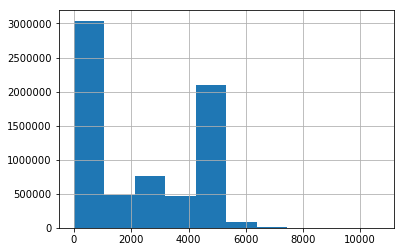

In [24]:
%matplotlib inline
raw['rmse'].hist(bins=10)

In [25]:
pd.qcut(raw['rmse'], 6);

## Thresholding on rmse of  300 meters.

In [26]:
filtered = raw[raw['rmse'] <= 300]

In [27]:
print filtered.shape
print raw.shape

(2650928, 12)
(6944466, 12)


## Deduping filtered, will represent networkidentifier with the centroid.

In [28]:
filtered_deduped = filtered.drop_duplicates('networkidentifier')

In [29]:
filtered_deduped = filtered_deduped.drop(['eventtime', 'accountid', 'latitude', 'longitude', 'networktype', 'distance_from_centeroid', 'distance_from_centeroid_mean', 'absdiff', 'rmse'], axis=1);

In [30]:
filtered_deduped.sort_values(['latitude_mean', 'longitude_mean'])

,networkidentifier,latitude_mean,longitude_mean
6477228,ac5c430a0af254f76a9222b722ba0e8f,12.658395,77.782174
6535741,1de1a6e6fdd617b83902dc9a9bca6ae4,12.659421,77.444918
3808306,4e6859b5cda71396807956a0c063998b,12.661305,77.749318
4564376,002ec0005ab62eb2a10134088a9eb4e6,12.661611,77.674662
944176,232b3d2634b248752b2283b15152aa19,12.661611,77.674662
3572730,a5b47056539c532515fe49548c673911,12.661769,77.746124
4988122,f11cd03d14046fe0675b9f140ceb4df6,12.664642,77.754896
6568049,2b9d2fffcead4879d56130cf6dcad9dd,12.664651,77.752016
1090813,c768dfbb90fad9e3d050ce0c4f6a5da0,12.664675,77.754791
5291069,b7afa3554d91a0188eb6bb03c9575040,12.664681,77.749582


## Testing discrepancies in the formula for calucaitng distance.

1. Calucating distances using the s2sphere's get_distance(), which uses lat longs.
2. Converting lat long into 3d vector. And calculating distance using euclidean_distance. 

If both are within tolerable range, will use euclidean_distance directly, to create KD/Ball Tree

In [31]:
ltlg1 = s2sphere.LatLng.from_degrees(28.629894, 77.219493)
p1 = ltlg1.to_point()
ltlg2 = s2sphere.LatLng.from_degrees(28.557125, 77.060695)
p2 = ltlg2.to_point()
print ltlg1.get_distance(ltlg2).radians * earthRadius

17488.4551368


In [32]:
from sklearn.metrics.pairwise import euclidean_distances
X = [[p1[0], p1[1], p1[2]]]
print euclidean_distances(X, [[p2[0], p2[1], p2[2]]])[0][0]*earthRadius

17488.4496462


## Within cities it doesn't matter which distance representaion is used. 

All distances are in meters.

## Creating a bbox around my apartment complex.

In [33]:
apartment = box(12.956787, 77.646059, 12.960801, 77.642484)
print apartment

POLYGON ((12.960801 77.64605899999999, 12.960801 77.642484, 12.956787 77.642484, 12.956787 77.64605899999999, 12.960801 77.64605899999999))


In [34]:
apartment_bbox = list(apartment.exterior.coords)
print apartment_bbox

[(12.960801, 77.646059), (12.960801, 77.642484), (12.956787, 77.642484), (12.956787, 77.646059), (12.960801, 77.646059)]


In [35]:
apartment_bounds_map = folium.Map( location=[12.96077,77.645139], zoom_start=30 )
for coord in apartment_bbox:
    folium.Marker( location=[ coord[0], coord[1] ] , icon=folium.Icon(color='red',icon='info-sign')).add_to( apartment_bounds_map )

## Engulfes my apartment and parts of the apartment next to mine and some commercial area including shops, offices and a hotel

## Utility which converts dataframe to follium map

In [36]:
def datafame_to_follium(df, lat_col, lng_col):
    lat = list(df[lat_col])
    lng = list(df[lng_col])
    latlon = zip(lat, lng)
    map_ = folium.Map( location=[lat[0],lng[0]], zoom_start=30 )
    is_first = True
    for coord in latlon:
        if is_first:
            folium.Marker( location=[ coord[0], coord[1] ], icon=folium.Icon(color='red',icon='info-sign') ).add_to(map_)
            is_first=False
        else:
            folium.Marker( location=[ coord[0], coord[1] ], icon=folium.Icon(color='green',icon='ok-sign') ).add_to(map_)
    return map_

## Calculating side lengths and patch area.

In [37]:
upper_right = s2sphere.LatLng.from_degrees(apartment_bbox[0][0], apartment_bbox[0][1])
upper_left = s2sphere.LatLng.from_degrees(apartment_bbox[1][0], apartment_bbox[1][1])
urul = upper_right.get_distance(upper_left).radians * earthRadius

In [38]:
lower_left = s2sphere.LatLng.from_degrees(apartment_bbox[2][0], apartment_bbox[2][1])
lower_right = s2sphere.LatLng.from_degrees(apartment_bbox[3][0], apartment_bbox[3][1])
lower_right.get_distance(lower_left).radians * earthRadius;

In [39]:
lrur = lower_right.get_distance(upper_right).radians * earthRadius

In [40]:
lower_left.get_distance(upper_left).radians * earthRadius;

In [41]:
areaofpatch =  urul*lrur
print 'Area of patch = ' + str(areaofpatch) + ' meter^2'

Area of patch = 172908.276432 meter^2


## Filtering rows if the mean of lat lon lies with this bbox. 

In [42]:
filtered.head()

,accountid,eventtime,latitude,longitude,networkidentifier,networktype,latitude_mean,longitude_mean,distance_from_centeroid,distance_from_centeroid_mean,absdiff,rmse
2302570,ACCFF3A39E229084B3D986066B468DBB5B83,2016-12-18 10:36:18.0,12.929757,77.670166,569212f260c094dc7a5e943d2dce88b1,WiFi,12.929091,77.669525,101.602583,258.685075,157.082493,299.963139
4334034,AC19THAY02Q9APWC6FCI4JE89MP5EW0N,2016-12-15 12:42:38.0,12.929757,77.670166,569212f260c094dc7a5e943d2dce88b1,WiFi,12.929091,77.669525,101.602583,258.685075,157.082493,299.963139
320346,ACCFF3A39E229084B3D986066B468DBB5B83,2016-12-04 08:48:05.0,12.929757,77.670166,569212f260c094dc7a5e943d2dce88b1,WiFi,12.929091,77.669525,101.602583,258.685075,157.082493,299.963139
2272544,ACCFF3A39E229084B3D986066B468DBB5B83,2016-12-18 09:54:37.0,12.929757,77.670166,569212f260c094dc7a5e943d2dce88b1,WiFi,12.929091,77.669525,101.602583,258.685075,157.082493,299.963139
5740247,ACCFF3A39E229084B3D986066B468DBB5B83,2016-12-27 21:23:05.0,12.929757,77.670166,569212f260c094dc7a5e943d2dce88b1,WiFi,12.929091,77.669525,101.602583,258.685075,157.082493,299.963139


In [43]:
def within(x):
    p = point.Point(x[2], x[3])
    return p.within(apartment)
filtered['dd'] = filtered.apply(within, axis=1)

/Users/karan.verma/miniconda2/envs/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [93]:
df_dd = filtered.loc[filtered.dd == True]

In [94]:
df_dd.shape

(3007, 13)

In [95]:
df_dd.describe(include=['O'])

,accountid,eventtime,networkidentifier,networktype
count,2955,3007,3007,3007
unique,455,2902,347,5
top,ACB1H0B4UW0O75Z6WJ9X6FLT8M5ZSU8U,2016-12-11 18:54:37.0,a5bd4301e6c358ee6f8f860ac2a9061d,WiFi
freq,169,3,175,2889


# Plotting them on the map.

Plot includes only the mean of lat long for unique account ids within the bbox around my apartment.

In [47]:
lat = list(df_dd['latitude_mean'])
lng = list(df_dd['longitude_mean'])
latlon = zip(lat, lng)

In [48]:
for coord in latlon:
    folium.Marker( location=[ coord[0], coord[1] ], icon=folium.Icon(color='green',icon='ok-sign') ).add_to( apartment_bounds_map )

# Analysing users in this patch

## Querying hive for data associated to list of accountids near my apartment.

In [62]:
accountids = list(set(list(df_dd['accountid'])))[1:]

In [64]:
def double_quote(word):
    double_q = '"' # double quote
    return double_q + word + double_q
accountids = double_quote(accountids)

In [77]:
query =  'SELECT data.accountid, data.firstname, data.lastname, data.active, data.phone, data.addressline1, data.addressline2, data.state, data.city,  data.pincode, data.lastmodified, data.addresscreation.creatingsystem, data.addresscreation.guest, data.addresscreation.creationdate FROM bigfoot_snapshot.dart_fkint_cp_user_address_6_0_view_total where  find_in_set(data.accountid, ' +accountids+ ')>0' 
def query_hive(query):
    cursor = hive.connect('prod-bheema-hive-2-1-0-0001',username='fk-bigfoot-read',configuration={'mapred.job.queue.name': 'adhoc'}).cursor()
    cursor.execute(query, async=True)

    status = cursor.poll().operationState
    while status in (TOperationState.INITIALIZED_STATE, TOperationState.RUNNING_STATE):
        logs = cursor.fetch_logs()
        for message in logs:
            print message
        status = cursor.poll().operationState
        
    data_hive = cursor.fetchall()
    return data_hive

## Converting hive query result to dataframe and saving to json file.

In [81]:
override = 0

In [78]:
hive_address_data_path= "../distances_samik_data/address_data.json"
if os.path.exists(hive_address_data_path) and os.path.getsize(hive_address_data_path) > 0:
    address_dataframe = pd.read_json(hive_address_data_path)
else:
    address_data_hive = query_hive(query)
    address_dataframe = pd.DataFrame(address_data_hive, columns=['accountid', 'firstname', 'lastname', 'active', 'phone', 'addressline1', 'addressline2', 'state', 'city',  'pincode', 'lastmodified', 'creatingsystem', 'guest', 'creationdate'])
    address_dataframe.to_json('../distances_samik_data/address_data.json')
if override:
    address_data_hive = query_hive(query)
    address_dataframe = pd.DataFrame(address_data_hive, columns=['accountid', 'firstname', 'lastname', 'active', 'phone', 'addressline1', 'addressline2', 'state', 'city',  'pincode', 'lastmodified', 'creatingsystem', 'guest', 'creationdate'])
    address_dataframe.to_json('../distances_samik_data/address_data.json')

In [80]:
address_dataframe.describe(include=['O'])

,accountid,addressline1,addressline2,city,creatingsystem,creationdate,firstname,lastmodified,lastname,phone,state
count,2428,2428,2371,2428,2401,2428,2428,2428,2428,2428,2428
unique,334,1879,681,237,1,2289,940,2259,544,956,24
top,AC9URZUIW7S1GVI7DGX6GJ9L1HC53E19,"No. 35, 1st floor, Main Kormangla road Adugodi",,Bangalore,web,2012-06-29 02:48:36.0,Ayush,2012-06-29 02:48:36.0,,9845234001,Karnataka
freq,34,9,1259,1183,2401,7,30,6,376,21,1433


### Joining address_dataframe with df_dd

In [102]:
address_dataframe

,accountid,active,addressline1,addressline2,city,creatingsystem,creationdate,firstname,guest,lastmodified,lastname,phone,pincode,state
0,ACB1H0B4UW0O75Z6WJ9X6FLT8M5ZSU8U,True,2/101 Viram Khand Gomti Nagar,,Lucknow,web,2012-06-29 09:33:21.0,Jitendra,False,2013-08-16 16:11:36.0,Upadhyay,9235694738,226010,Uttar Pradesh
1,ACC13484062779551064,True,"#132,8th cross,sai nagar phase-2,near sambhara...",,bangalore,web,2012-09-24 23:16:34.0,nitish,True,2013-08-17 10:52:41.0,,8904099306,560097,Karnataka
10,ACO7W3VU1KG1K58OF7DPUTBG9XKVQNKI,True,A 704/NPSC Society/Sec-2/Plot-5/Dwarka,,New Delhi,web,2014-10-12 20:35:24.0,Dr Jagannath,False,2014-10-12 20:35:24.0,Sharma,9560520000,110075,Delhi
100,ACTWA5U93UEKZ7F6KKF7WVSTKNQHAVYX,True,"BF2, Guru Paradise, No. 27, 7th Cross Street, ...",Near Hindu Mission Hospital,Chennai,web,2012-07-13 02:28:39.0,Vineeth Ravi,False,2012-07-13 02:28:39.0,Varma,9884257237,600601,Tamil Nadu
1000,ACGMOSPOI41UG6XDUGYFV4M3TKSR3ZIH,False,"55-14-113, APSEB COLONY,SEETHAMMADHARA",Near Sita Rama Raju Statue,Vishakhapatnam,web,2014-03-22 16:29:07.0,Rama Krishna,False,2015-06-03 14:50:51,Sunnam,9701498499,530013,Andhra Pradesh
1001,ACZELUJAQCZJ1S2OIOTSVEQSCIRLJY60,True,Target Corporation India Pvt. Ltd Robert J Ulr...,,Bangalore,web,2014-05-01 00:29:20.0,seemant,False,2015-06-07 19:20:30,,9538501112,560071,Karnataka
1002,ACONBLG4DBWBQ31F7P429DWM64NHUCQN,False,"Gate No. 1, Infosys Limited, Hosur Road","Electronics City, Phase 1",Bangalore,web,2014-05-19 22:31:55.0,Pankaj,False,2015-03-31 18:11:59,Kunwar,9538834112,560100,Karnataka
1003,ACO7WEVT5RC9N89O62VYPY1HF4XCCZI0,False,"A6, Telecom Officers Complex, Telephone Exchan...",,Hyderabad,web,2014-07-13 15:35:55.0,Balasubrahmanyam,False,2014-07-13 15:37:34.0,V,9494526699,500025,Andhra Pradesh
1004,ACXOIA5YJSRIDZ6P4IT0SLLDLDJE1R9G,True,"RP HALL ,IIT KHARAGPUR ROOM NO. C-330",,KHARAGPUR,web,2014-07-15 17:20:21.0,UTKARSH,True,2014-07-15 17:20:45.0,LOHIYA,9434353875,721302,West Bengal
1005,ACOLOQKYB4LIA8ZHA35AIM5N70ZXRR8V,True,"# 14, Old Airport Road, Kodihalli opp to diamo...",Suri Bar & Restaurant,Bangalore,web,2014-07-17 18:07:21.0,arjun,True,2014-07-17 18:07:53.0,gowda,9902585444,560008,Karnataka


In [104]:
df_dd.describe(include=['O'])

,accountid,eventtime,networkidentifier,networktype
count,2955,3007,3007,3007
unique,455,2902,347,5
top,ACB1H0B4UW0O75Z6WJ9X6FLT8M5ZSU8U,2016-12-11 18:54:37.0,a5bd4301e6c358ee6f8f860ac2a9061d,WiFi
freq,169,3,175,2889


In [105]:
df_dd_joined = df_dd.join(address_dataframe, on='accountid', rsuffix='_r')

In [110]:
df_dd_joined.describe(include=['O'])

,accountid,eventtime,networkidentifier,networktype,addressline1,addressline2,city,creatingsystem,creationdate,firstname,lastmodified,lastname,phone,state
count,17579,17579,17579,17579,17579,17366,17579,17487,17579,17579,17579,17579,17579,17579
unique,334,2068,242,5,1879,681,237,1,2289,940,2259,544,956,24
top,ACB1H0B4UW0O75Z6WJ9X6FLT8M5ZSU8U,2016-12-04 15:04:13.0,a5bd4301e6c358ee6f8f860ac2a9061d,WiFi,"D5/367C, Vikas Khand, Gomti Nagar",,Bangalore,web,2012-06-29 09:33:21.0,Abhilasha,2014-08-18 14:55:22.0,Upadhyay,9620274302,Karnataka
freq,3718,54,3826,17116,676,9212,8782,17487,676,1183,338,2559,1183,11011


In [109]:
df_dd_joined = pd.merge(df_dd, address_dataframe, on='accountid', sort=False)

In [115]:
df_dd_joined = df_dd_joined.drop(['distance_from_centeroid', 'distance_from_centeroid_mean', 'absdiff', 'rmse', 'dd',  u'creatingsystem', u'creationdate', u'guest'], axis=1)

### Getting derived account data

In [ ]:
override = 0

In [119]:
query =  'SELECT data FROM bigfoot_snapshot.dart_fkint_cp_uie_derived_account_3_0_view_total where  find_in_set(entityid, ' +accountids+ ')>0'
hive_derived_account_data_path= "../distances_samik_data/derived_account_data.json"
if os.path.exists(hive_derived_account_data_path) and os.path.getsize(hive_derived_account_data_path) > 0:
    derived_account_dataframe = pd.read_json(hive_derived_account_data_path)
else:
    derived_account_hive = query_hive(query)
    derived_account_dataframe = pd.DataFrame(derived_account_hive, columns=['accountid', 'firstname', 'lastname', 'active', 'phone', 'addressline1', 'addressline2', 'state', 'city',  'pincode', 'lastmodified', 'creatingsystem', 'guest', 'creationdate'])
#     derived_account_dataframe.to_json(hive_derived_account_data_path)
if override:
    derived_account_hive = query_hive(query)
    address_dataframe = pd.DataFrame(address_data_hive, columns=['accountid', 'firstname', 'lastname', 'active', 'phone', 'addressline1', 'addressline2', 'state', 'city',  'pincode', 'lastmodified', 'creatingsystem', 'guest', 'creationdate'])
    address_dataframe.to_json('../distances_samik_data/address_data.json')

AssertionError: 14 columns passed, passed data had 1 columns

In [133]:
derived_account_hive = [json.loads(data[0]) for data in derived_account_hive]

In [135]:
derived_account_df = pd.DataFrame(derived_account_hive)

In [136]:
derived_account_df

,account_id,app_visits,creation_date_ts,customer_type,first_name,first_purchase_date_ts,gender_behavior,gender_name,is_active,is_blacklisted,...,last_visit_ts,no_of_orders,no_of_visits,purchase_amount_range,recency_tag,rfm_segment,single_or_multi_category,total_order_value,visits_per_order,web_visits
0,AC7XTZ67LRJZD6HHFQI7DYEMKO1RPVFN,4326.0,None,loyal,"{u'confidence': 100.0, u'value': u'Apuarv'}",2011-07-22 15:01:56,"{u'female_confidence': 0.0874055741844, u'cant...","{u'female_confidence': 0.0, u'cant_say_confide...",False,False,...,2016-03-04 11:28:18.961,67,10802.0,"{u'max': {u'currency': u'INR', u'amount': 1629...",New Active,Platinum,Multiple,191003.00,161.0,10141.0
1,ACORGR2S6FM3K8VQ1LBQNRFU99V1P8J9,117.0,None,regular,"{u'confidence': 100.0, u'value': u'snemax'}",2011-05-24 16:17:10,"{u'female_confidence': 11.9517923789, u'cant_s...","{u'female_confidence': 0.0, u'cant_say_confide...",False,False,...,2015-11-02 18:35:59.897,10,849.0,"{u'max': {u'currency': u'INR', u'amount': 1999...",Recent Inactive,Platinum,Multiple,93498.00,84.0,835.0
2,ACC14216585207447178,4509.0,None,loyal,"{u'confidence': 100.0, u'value': u'Nikita.Lall...",2015-01-19 14:41:58,"{u'female_confidence': 5.77928464827, u'cant_s...","{u'female_confidence': 100.0, u'cant_say_confi...",False,None,...,2016-03-16 17:48:27.293,35,699.0,"{u'max': {u'currency': u'INR', u'amount': 6499...",New Active,Platinum,Multiple,30119.00,19.0,NaN
3,ACC13734682145193844,NaN,None,irregular,"{u'confidence': 100.0, u'value': u'Nikhita'}",2013-10-15 13:35:57,"{u'female_confidence': 46.2249690082, u'cant_s...","{u'female_confidence': 100.0, u'cant_say_confi...",False,None,...,2016-03-15 23:57:11.847,4,2595.0,"{u'max': {u'currency': u'INR', u'amount': 1999...",Recent Inactive,Silver,Multiple,22781.00,648.0,2595.0
4,ACC14083465615604521,1299.0,None,loyal,"{u'confidence': 100.0, u'value': u'NISCHITH BO...",2015-08-15 00:06:33,"{u'female_confidence': 6.10533968371, u'cant_s...","{u'female_confidence': 0.0, u'cant_say_confide...",False,None,...,2016-03-11 14:43:21.517,5,1155.0,"{u'max': {u'currency': u'INR', u'amount': 6999...",New Active,Gold,Multiple,13935.00,231.0,1026.0
5,ACC13596099912358106,10409.0,None,loyal,"{u'confidence': 100.0, u'value': u'Prashant '}",2013-08-04 23:52:54,"{u'female_confidence': 6.55511777784e-06, u'ca...","{u'female_confidence': 0.0, u'cant_say_confide...",False,None,...,2016-03-18 11:39:44.346,51,31283.0,"{u'max': {u'currency': u'INR', u'amount': 1482...",New Active,Platinum,Multiple,131000.00,613.0,28881.0
6,ACC13771866936055988,5394.0,None,regular,"{u'confidence': 100.0, u'value': u'Shwetha'}",2015-06-29 16:56:50,"{u'female_confidence': 99.7518738841, u'cant_s...","{u'female_confidence': 100.0, u'cant_say_confi...",False,None,...,2016-01-15 16:24:07.427,10,3919.0,"{u'max': {u'currency': u'INR', u'amount': 1011...",Recent Inactive,Gold,Multiple,15801.00,391.0,3475.0
7,ACCF72E012A142E43CCA98DD55DA580963EL,240.0,None,,"{u'confidence': 100.0, u'value': u'Neha'}",2015-07-04 17:04:24,"{u'female_confidence': 58.9547407901, u'cant_s...","{u'female_confidence': 99.358974359, u'cant_sa...",False,None,...,2015-11-12 12:44:22.481,5,428.0,"{u'max': {u'currency': u'INR', u'amount': 9999...",New Active,Bronze,Multiple,15403.00,85.0,367.0
8,ACC064A39F29B1B40588EFE15A4679D9FABI,1137.0,None,new / trial,"{u'confidence': 100.0, u'value': u'J SRINIVAS'}",2015-10-15 11:13:00,"{u'female_confidence': 1.65892241278, u'cant_s...","{u'female_confidence': 0.0, u'cant_say_confide...",False,None,...,2016-01-01 15:30:59.878,2,478.0,"{u'max': {u'currency': u'INR', u'amount': 9079...",New Active,Silver,Single,18158.00,239.0,429.0
9,ACLGQ73D9UBJ5DOXWKHBMOW1YZVS1DI3,6270.0,None,loyal,"{u'confidence': 100.0, u'value': u'Gaurav'}",2012-04-24 09:09:31,"{u'female_confidence': 0.100545519889, u'cant_...","{u'female_confidence': 0.0, u'cant_say_confide...",False,False,...,2016-01-31 18:59:05.981,35,8631.0,"{u'max': {u'currency': u'INR', u'amount': 2599...",New Active,Platinum,Multiple,104856.

# Indexing to KD/Ball Tree

In [ ]:
all_data_ssid_dedup = filtered.drop_duplicates('networkidentifier')

In [ ]:
all_data_ssid_dedup = all_data_ssid_dedup.drop(['eventtime','networktype','distance_from_centeroid', 'distance_from_centeroid_mean', 'absdiff', 'rmse'], axis=1)

In [ ]:
all_data_ssid_dedup = all_data_ssid_dedup.reset_index(drop=True)

In [ ]:
all_data_ssid_dedup.head();

In [ ]:
def to_point(row):
    ltlg = s2sphere.LatLng.from_degrees(row[1], row[2])
    p = ltlg.to_point()
    return pd.Series([p[0], p[1], p[2]])
        
all_data_ssid_dedup[['x', 'y', 'z']] = all_data_ssid_dedup.apply(to_point, axis=1)

In [ ]:
all_data_ssid_dedup.loc[:100];

In [ ]:
X = all_data_ssid_dedup.drop(['accountid', 'networkidentifier', 'latitude_mean', 'longitude_mean', 'latitude', 'longitude'], axis=1)
Y = X.as_matrix()

In [ ]:
tree = KDTree(Y) 

In [ ]:
dist, ind = tree.query([Y[0]], k=1500) 
check_this = all_data_ssid_dedup.iloc[ind.tolist()[0]]


In [ ]:
datafame_to_follium(check_this, 'latitude', 'longitude')